## Simulador de la Cuenca de Salgar

El siguiente codigo se encarga de simular la cuenca de salgar a partir de la informacion de radar obtenida por Julian, para el evento de Mayo 20.  

La siguiente celda inicia los paquetes necesarios, 
esta simulación se realiza como un primer ensayo del nuevo paquete WMF, el cual no ha sido probado 

In [1]:
%matplotlib inline
from wmf import wmf 
from fwm import utils
import numpy as np
import pylab as pl

Lectura de mapas de direcciones y de elevación:

In [2]:
DEM=wmf.read_map_raster('raster/dem2.tif',True)
DIR=wmf.read_map_raster('raster/dir.tif',True)
wmf.cu.nodata=-9999.0; wmf.cu.dxp=30.0
DIR[DIR<=0]=wmf.cu.nodata.astype(int)
DIR=wmf.cu.dir_reclass(DIR,wmf.cu.ncols,wmf.cu.nrows)

___

## Trazado de la cuenca y preparación de la misma 

A continuación se traza la cuenca de salgar y se preparan los parametros geomorfológicos y físicos, posteriormente se establecen las
condiciones para la simulación

In [3]:
# Trazado de la cuenca 
cuSalgar = wmf.SimuBasin(-75.9808, 5.9647, DEM, DIR, name='Liboriana',
    dt = 300)

In [4]:
# Establecer Parametros Geomorfo
cuSalgar.GetGeo_Cell_Basics()
cuSalgar.set_Geomorphology(stream_width=cuSalgar.CellLong)

### Parámetros físicos.

Los parámetros físicos del modelo se dividen en velocidades verticales y vel horizontales,  las cuales a su ves se dividen en versiones lineales y no lineales de las mismas, en el caso de las velocidades verticales todas las relaciones son lineales, a continuación se describen las variables relacionadas con los flujos que se encuentran en el modelo:

- Velocidades Verticales:
    - Tanque 1 a exterior (evaporacion): controlado por $EVP$, en el modelo se representa como **vspeed(1,:) = v_coef(1,:)R[1]dt**
    - Tanque 1 a Tanque 2 (Sat del capilar): controlado por $H_u$ y por la precipitación $P_{t}$.
    - Tanque 2 a Tanque 3 (infiltracion): controlado por $k_s$, el cual en el modelo se representa mediante **vspeed(2,:) = v_coef(2,:)R[2]dt**
    - Tanque 3 a Tanque 4 (percolación): controlado por $k_p$ el cual en el modelo se representa mediante **vspeed(3,:) = v_coef(3,:)R[3]dt**
    - Tanque 4 a Perdidas (perdidas); controlado por $k_{pp}$ en el modelo se presenta como **vspeed(4,:) = v_coef(4,:)R[4]dt**
    
    
- Velocidades Horizontales:
    - Salida Tanque 2: Se representa como $v_2$ y en el modelo esta atada a: **hspeed(1,:) = h_coef(1,:)R[5]** en el caso lineal, y en el no lineal se involucra el termino **h_exp(1,:)**
    - Salida Tanque 3: Se representa como $k_{sh}$ o $v_{3}$ en el modelo se muestra commo: **hspeed(2,:) = h_coef(2,:)R[6]**, enn el caso no lineal el termino **h_exp(2,:)** entra.
    - Salida Tanque 4: Se representa como $k_{ph}$ o $v_{4}$ en el modelo se muestra commo: **hspeed(3,:) = h_coef(3,:)R[7]**, en el caso no lineal el término **h_exp(3,:)** se tiene en cuenta.
    - Salida Tanque 5: Se representa como $v_{5}$, el modelo esta atado a **h_coef(4,:)** y a **h_exp(4,:)**, siempre es no lineal, en calibración el parámetro **R[8]** es el responsable.

- Almacenamientos:
    - Almacenamiento capilar: **H(1,:) = Max_capilar(1,:) R[9]**
    - Almacenamiento gravitacional: **H(2,:) = Max_gravita(1,:) R[10]**

La calibración se compone de 10 parámetros escalares, los cuales son:
- R[1] : Evaporación.
- R[2] : Infiltración.
- R[3] : Percolación.
- R[4] : Pérdidas.
- R[5] : Vel Superficial.
- R[6] : Vel Sub-superficial.
- R[7] : Vel Subterranea.
- R[8] : Vel Cauces.
- R[9] : Alm capilar maximo.
- R[10] : Alm gravitacional maximo.

### Preparación parámetros verticales 

- **EVP**: se asume según la ecuación de Turc y se divide por el tamano de $\delta t$.
- **ks**: se asume contante para toda la cuenca e igual a $1mm/h$.
- **kp**: se va a asumir como dos ordenes de magnitud por debajo de **ks**.

In [5]:
# Evaporación en la cuenca estimada por Turc.
Evp=4.658*np.exp(-0.0002*cuSalgar.CellHeight)/288.0
# Infiltración Ks 
Ks = 0.00028
# Percolación 
Kp = Ks/100.0
# Perdidas se asumen iguales a cero 
Kpp = 0.0
# Inclusión de los parámetros en el modelo 
Lista=[Evp,Ks,Kp,Kpp]
for pos,var in enumerate(Lista):
    cuSalgar.set_PhysicVariables('v_coef',var,pos)


### Preparación parámetros horizontales

- **v2**: velocidad superficial se asume igual a 0.1 m/seg.
- **v3**: velocidad sub-superficial se asume igual a $k_s$.
- **v4**: velocidad subterranea asumida igual a $k_p$.

In [6]:
# Velocidades superficial, sub-super, y subte.
v2 = 1.4 * cuSalgar.CellSlope**0.5
v3 = Ks * cuSalgar.CellSlope**0.5
v4 = Kp * cuSalgar.CellSlope**0.5
Lista=[v2,v3,v4]
for pos,var in enumerate(Lista):
    cuSalgar.set_PhysicVariables('h_coef',var,pos)

In [7]:
v2.mean()

1.0770053

A continuación se presentan los valores que tendrían los 3 tanques lineales en el modelo para el caso en que se usen los coeficientes de calibración R[5] = 1.0, R[6] = 1000 y R[7] = 1800

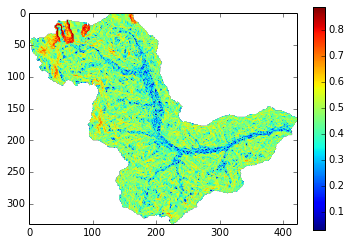

Tasa transferencia Media [%]: 0.456699


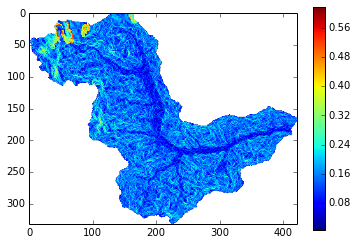

Tasa transferencia Media [%]: 0.151179


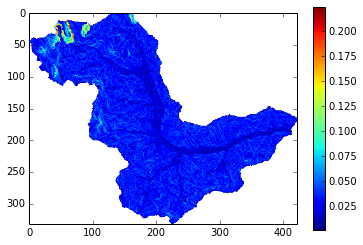

Tasa transferencia Media [%]: 0.0318698


In [8]:
#Si uno calcula los coeficientes lineales de salida de cada tanque
calib = [0.1, 100, 1800]
hflux=[]
for c,v in zip(calib,Lista):
    hflux.append(1.0 - (wmf.models.hill_long/(c*v*300 + wmf.models.hill_long)) )
for h in hflux:
    utils.plot_basin_map(cuSalgar.structure,h,cuSalgar.ncells)
    print 'Tasa transferencia Media [%]: ' + str(h.mean())

### Preparación parámetros en el cauce 

para preparar los parámetros del cauce se deben calcular el coeficiente y el exponente que tienen que ser resueltos para obtener el flujo.



In [9]:
#Calcula variable para el coeficiente horizontal 
area = cuSalgar.CellAcum * (30**2)
var,w1 = wmf.OCG_param(pend = cuSalgar.CellSlope, area = area)
cuSalgar.set_PhysicVariables('h_coef',var,3)
#Variable del exponente horizontal 
cuSalgar.set_PhysicVariables('h_exp',w1,3)

### Prepara puntos de control y tipo de velocidad a usar 

>En este caso solo se registran caudales a la salida de la cuenca.
y el tipo de velocidad es lineal para todos los tanques excepto para el 5to, en donde la velocidad siempre es cinematica.

In [10]:
cuSalgar.set_record()
cuSalgar.set_speed_type()

___
## Ejecución modelo
A continuación se realiza una ejecución ensayo del modelo, ojo esta es una prueba inicial puede fallar facilmente 

___

#### De nuevo calibración 

La calibración se compone de 10 parámetros escalares, los cuales son:
- R[1] : Evaporación.
- R[2] : Infiltración.
- R[3] : Percolación.
- R[4] : Pérdidas.
- R[5] : Vel Superficial.
- R[6] : Vel Sub-superficial.
- R[7] : Vel Subterranea.
- R[8] : Vel Cauces.
- R[9] : Alm capilar maximo.
- R[10] : Alm gravitacional maximo.

In [11]:
#wmf.models.storage = Res['Storage']
cuSalgar.set_storage(10,3)
Calibracion = [0.5, 1.0, 1.0, 0.0, 1.0, 1000, 2800, 0.999, 0.005, 1.0]
ruta_lluvia = 'lluvia/lluvia_201501010000_201501312355.bin'
Res = cuSalgar.run_shia(Calibracion,ruta_lluvia,100,7200)

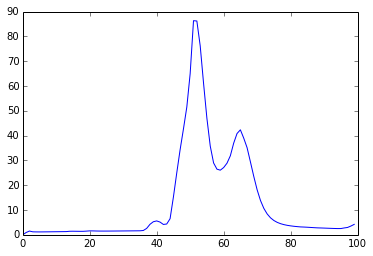

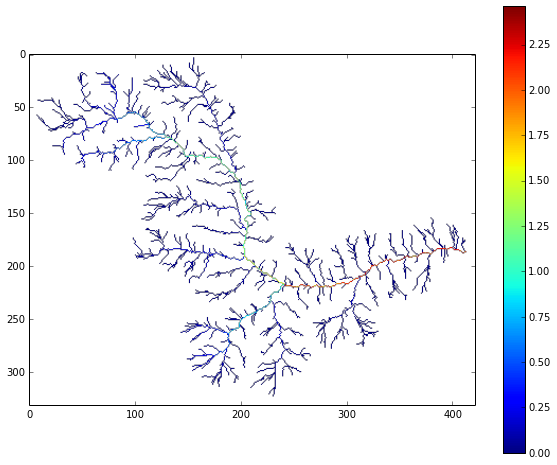

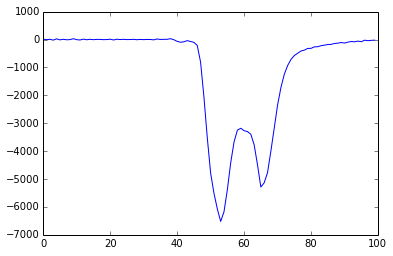

In [12]:
pl.plot(Res['Qsim'][0])
cuSalgar.Plot_basin_fast(Res['Storage'][4],ZeroAsNaN='si')
pl.plot(Res['Balance'])

___
# Modelo por laderas 

A continuación se realiza un ensayo similar pero simulando por laderas, este ejercicio pretende ejecutar por privera ves el modelo en un esquema de laderas y canales y no de celdas.

## Variaciones a resaltar:

En el modelo de ladar cabe destacar las siguientes distinciones 

### Laderas:
>- La ecuación de continuidad en laderas es afectada, de manera que:
$E_{i} = \left(1- \frac{L_{ladera}}{L_{ladera} + v_{i} \Delta t } \right) S_{i,t}$, para $i$ en tanques 2, 3 y 4.

### Canales:
>- La ecuación en los canales queda descrita de la siguiente manera:
$A_{sec,i,t} = \frac{S_{5,t}F_{conv}}{L_{canal}+v_{5,t}\Delta t}$, donde $F_{conv} = W_{canal} L_{canal} / 1000 [m^2/mm]$
El ancho del canal esta dado en función del área acumulada.

### En General:
>- Todos los elementos de la cuenca se identifican como elementos con un cauce interior por lo tanto todos son elementos tipo 3 **[models.unit_type=3]**.

In [13]:
# Trazado de la cuenca 
cuSalgar = wmf.SimuBasin(-75.9808, 5.9647, DEM, DIR, name='Liboriana',
    dt = 300, modelType = 'hills',umbral=500)
cuSalgar.GetGeo_Cell_Basics()

### Obtención del ancho en función del Qmed.

Para obtener el ancho de cada canal este se calcula en función del caudal medio (Leopold y Maddok, 1953). Se puede usar la siguiente expresión:

- 1 $W = c Q^\varepsilon$ 
- 2 $Q_b = k \Lambda ^{\varphi}$

Por lo tanto se puede aproximar el ancho de la siguiente manera:

- 3 $W = c k \Lambda ^{\varphi \varepsilon}$ Tomado de Vélez, 2001.
- 4 $W = K_{w} \Lambda ^{\varphi (\varepsilon_1 - \varepsilon_2)} Q^{\varepsilon_2}$

Para la ecuación 1, Mejía y Posada (2002) encuentran que el valor más acertado de exponente para la región andina es $0.46$, Leopold (1953) indica que este valor puede oscilar entre $0.42$ y $0.55$, como coeficiente encuentran un valor igual a $2.261$, de esta forma la ecuación queda: 

- 5 $W = 2.261 Q ^{0.46}$, con un error del $18\%$

In [50]:
#Calcula el caudal medio
cuSalgar.GetQ_Balance(3000,Tipo_ETR=1)
#Basado en el Q medio calcula el ancho
W = 2.261*cuSalgar.CellQmed**0.46
#Obtiene los parametros geomorfo
cuSalgar.set_Geomorphology(stream_width=W,umbrales=[30, 500])
# Inclusión de los parámetros en el modelo 
Lista=[Evp,Ks,Kp,Kpp]
for pos,var in enumerate(Lista):
    cuSalgar.set_PhysicVariables('v_coef',var,pos)

___
### Ensayo con velocidades horizontales 

A continuación se realiza un ensayo con las vel hztales, esto con la finalidad de observar como se comportan estos parámetros en un caso de laderas y no de celdas.

In [51]:
v2 = 1.4 * cuSalgar.CellSlope**0.5
v3 = Ks * cuSalgar.CellSlope**0.5
v4 = Kp * cuSalgar.CellSlope**0.5
Lista=[v2,v3,v4]
for pos,var in enumerate(Lista):
    cuSalgar.set_PhysicVariables('h_coef',var,pos)

A cotninuación se pasan las velocidades que se encuentran en forma de celda a forma de ladera 

In [16]:
ListaHills=[]
for var in Lista:
    ListaHills.append(cuSalgar.Transform_Basin2Hills(var))

Ahora se calcula como sería la cantidad de agua transportada por cada ladera con esas velocidades (asumiendo un omportamiento lineal):

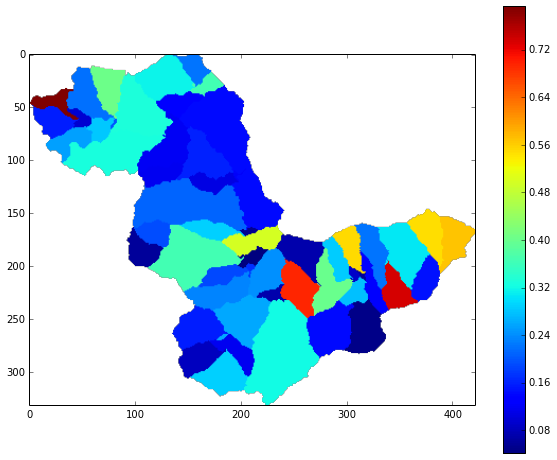

Tasa transferencia Media [%]: 0.253499


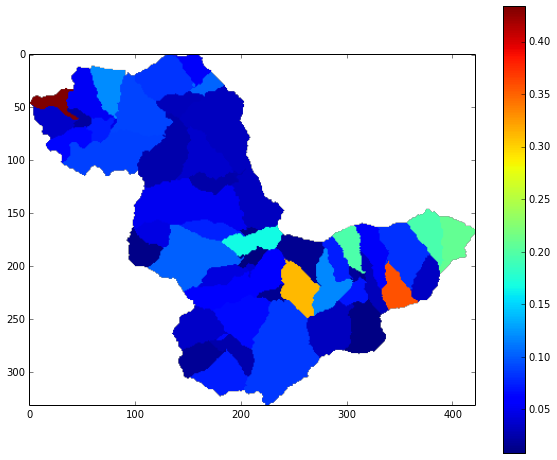

Tasa transferencia Media [%]: 0.0776728


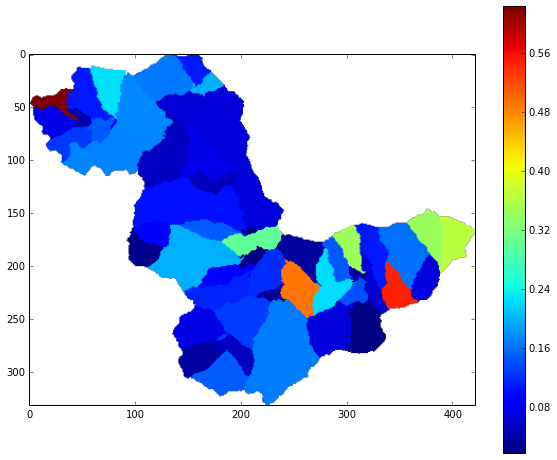

Tasa transferencia Media [%]: 0.142589364951


In [397]:
#Si uno calcula los coeficientes lineales de salida de cada tanque
calib = [0.5, 500, 108000]
hflux=[]
for c,v in zip(calib,ListaHills):
    hflux.append(1.0 - (wmf.models.hill_long/(c*v*300 + wmf.models.hill_long)) )
for h in hflux:
    hBasin = cuSalgar.Transform_Hills2Basin(h[0])
    cuSalgar.Plot_basin_fast(hBasin)
    print 'Tasa transferencia Media [%]: ' + str(h.mean())

___
### Parametros de flujo horizontal en el cause 
Preparación parámetros en el cauce
para preparar los parámetros del cauce se deben calcular el coeficiente y el exponente que tienen que ser resueltos para obtener el flujo.

In [53]:
#Calcula variable para el coeficiente horizontal 
area = cuSalgar.CellAcum * (30**2)
var,w1 = wmf.OCG_param(pend = cuSalgar.CellSlope, area = area)
cuSalgar.set_PhysicVariables('h_coef',var,3,mask=cuSalgar.CellCauce)
#Variable del exponente horizontal 
cuSalgar.set_PhysicVariables('h_exp',w1,3,mask=cuSalgar.CellCauce)

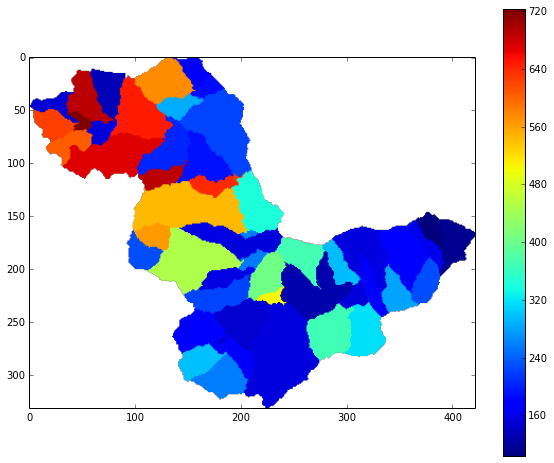

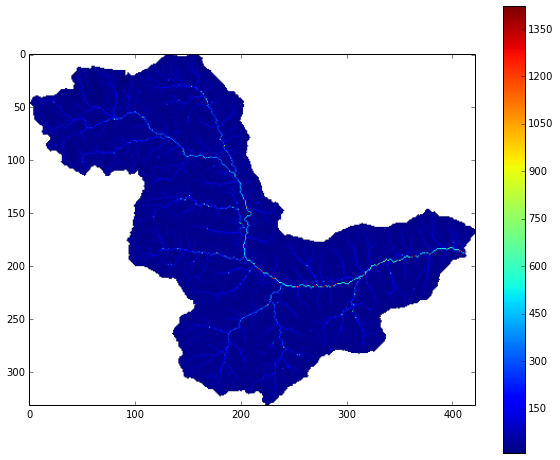

In [84]:
a = cuSalgar.Transform_Hills2Basin(wmf.models.h_coef[3])
cuSalgar.Plot_basin_fast(a)
cuSalgar.Plot_basin_fast(var)

___
### Ejecucion del modelo en ladera 

A continuación se realiza un primer ensayo de la ejecución del modelo en su versión de ladera, esta es puramente experimental.

La calibración se compone de 10 parámetros escalares, los cuales son:
- R[1] : Evaporación.
- R[2] : Infiltración.
- R[3] : Percolación.
- R[4] : Pérdidas.
- R[5] : Vel Superficial.
- R[6] : Vel Sub-superficial.
- R[7] : Vel Subterranea.
- R[8] : Vel Cauces.
- R[9] : Alm capilar maximo.
- R[10] : Alm gravitacional maximo.

3.36191


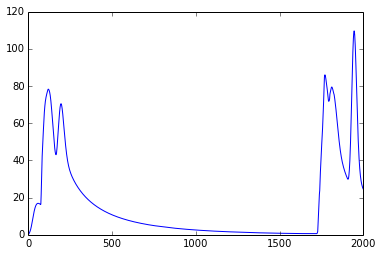

In [493]:
Calibracion = [0.8, 100, 100, 0.0, 20, 90, 50, 0.3, 1, 1]
ruta_lluvia = 'lluvia/lluvia_lad_201505010000_201505312355.bin'
Res = cuSalgar.run_shia(Calibracion,ruta_lluvia,2000,1500)

pl.plot(Res['Qsim'][0])
print Res['Qsim'][0][800:1000].mean()

for i in range(4):
    cuSalgar.set_storage(Res['Storage'][i],i)

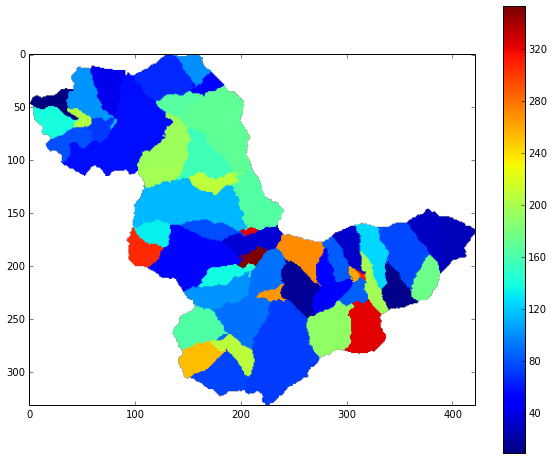

1.48362854123


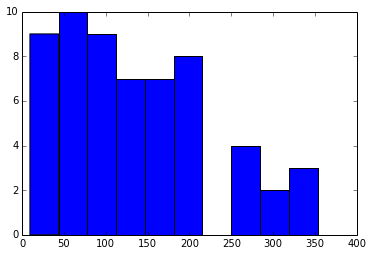

In [494]:
pos = 3
s = cuSalgar.Transform_Hills2Basin(Res['Storage'][pos])
cuSalgar.Plot_basin_fast(s)
pl.hist(Res['Storage'][pos])
print np.percentile(Res['Qsim'][0],25)

In [359]:
Kp

2.8e-06